In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# 🔧 AUTO-FIX LeafGAN TabError (Python 3.12 Safe)
# This cell OVERWRITES leaf_gan_model.py with clean indentation
# ============================================================

import os
from textwrap import dedent

LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
MODEL_FILE = os.path.join(LEAFGAN_ROOT, "models", "leaf_gan_model.py")

assert os.path.exists(LEAFGAN_ROOT), "❌ LeafGAN root not found!"
assert os.path.exists(os.path.dirname(MODEL_FILE)), "❌ models/ folder missing!"

print("🛠️ Fixing:", MODEL_FILE)

fixed_code = dedent("""
import torch
from .base_model import BaseModel
from . import networks


class LeafGANModel(BaseModel):
    \"\"\"LeafGAN model (CycleGAN-based)\"\"\"

    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)

        self.isTrain = opt.isTrain
        self.is_using_mask = opt.dataset_mode == "unaligned_masked"

        self.loss_names = [
            "G_A", "G_B",
            "D_A", "D_B",
            "cycle_A", "cycle_B",
            "idt_A", "idt_B"
        ]

        self.visual_names = ["real_A", "fake_B", "real_B", "fake_A"]

        self.model_names = ["G_A", "G_B"]
        if self.isTrain:
            self.model_names += ["D_A", "D_B"]

        self.netG_A = networks.define_G(
            opt.input_nc, opt.output_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        self.netG_B = networks.define_G(
            opt.output_nc, opt.input_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        if self.isTrain:
            self.netD_A = networks.define_D(
                opt.output_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.netD_B = networks.define_D(
                opt.input_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()

            self.optimizer_G = torch.optim.Adam(
                list(self.netG_A.parameters()) +
                list(self.netG_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizer_D = torch.optim.Adam(
                list(self.netD_A.parameters()) +
                list(self.netD_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        self.real_A = input["A"].to(self.device)
        self.real_B = input["B"].to(self.device)
        self.image_paths = input["A_paths"]

    def forward(self):
        self.fake_B = self.netG_A(self.real_A)
        self.fake_A = self.netG_B(self.real_B)

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, self.fake_B)

    def backward_D_B(self):
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, self.fake_A)

    def backward_G(self):
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        lambda_idt = self.opt.lambda_identity

        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)

        rec_A = self.netG_B(self.fake_B)
        rec_B = self.netG_A(self.fake_A)

        self.loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * lambda_B

        idt_A = self.netG_A(self.real_B)
        idt_B = self.netG_B(self.real_A)

        self.loss_idt_A = self.criterionIdt(idt_A, self.real_B) * lambda_B * lambda_idt
        self.loss_idt_B = self.criterionIdt(idt_B, self.real_A) * lambda_A * lambda_idt

        self.loss_G = (
            self.loss_G_A + self.loss_G_B +
            self.loss_cycle_A + self.loss_cycle_B +
            self.loss_idt_A + self.loss_idt_B
        )

        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()

        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()
""")

with open(MODEL_FILE, "w") as f:
    f.write(fixed_code)

print("✅ leaf_gan_model.py replaced successfully!")
print("🔁 PLEASE RESTART RUNTIME before training")


🛠️ Fixing: /content/drive/MyDrive/LeafGAN-master/models/leaf_gan_model.py
✅ leaf_gan_model.py replaced successfully!
🔁 PLEASE RESTART RUNTIME before training


In [ ]:

#SET ROOT PATH OF HEALTHY AND DISEASED LEAF
import os, shutil

healthy_src = "/content/drive/MyDrive/HEALTHY"
anthracnose_src = "/content/drive/MyDrive/ANTHRECNOSE/class1"

leafgan_root = "/content/drive/MyDrive/LEAFGAN_AnthraDATA"
trainA = os.path.join(leafgan_root, "trainA")  # Healthy
trainB = os.path.join(leafgan_root, "trainB")  # Anthracnose

os.makedirs(trainA, exist_ok=True)
os.makedirs(trainB, exist_ok=True)

# Copy Healthy images → trainA
for f in os.listdir(healthy_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(healthy_src, f), trainA)

# Copy Anthracnose images → trainB
for f in os.listdir(anthracnose_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(anthracnose_src, f), trainB)

print("✅ LeafGAN dataset created successfully")
print("Healthy → trainA | Anthracnose → trainB")


KeyboardInterrupt: 

In [ ]:
!pip install dominate visdom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=3d7080948a267c1223835d9bf51a7c7360a8ffb3fc931d7ba51493b3125e655f
  Stored in directory: /root/.cache/pip/wheels/37/6c/38/64eeaa310e325aacda723e6df1f79ab5e9f31ba195264e04a8
Successfully built visdom


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/LeafGAN-master


/content/drive/MyDrive/Colab Notebooks/LeafGAN-master


In [ ]:
!mv "/content/drive/MyDrive/Colab Notebooks/LeafGAN-master" \
     "/content/drive/MyDrive/LeafGAN-master"


In [ ]:
# ============================================================
# 🔧 AUTO-FIX LeafGAN TabError (Python 3.12 Safe)
# This cell OVERWRITES leaf_gan_model.py with clean indentation
# ============================================================

import os
from textwrap import dedent

LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
MODEL_FILE = os.path.join(LEAFGAN_ROOT, "models", "leaf_gan_model.py")

assert os.path.exists(LEAFGAN_ROOT), "❌ LeafGAN root not found!"
assert os.path.exists(os.path.dirname(MODEL_FILE)), "❌ models/ folder missing!"

print("🛠️ Fixing:", MODEL_FILE)

fixed_code = dedent("""
import torch
from .base_model import BaseModel
from . import networks


class LeafGANModel(BaseModel):
    \"\"\"LeafGAN model (CycleGAN-based)\"\"\"

    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)

        self.isTrain = opt.isTrain
        self.is_using_mask = opt.dataset_mode == "unaligned_masked"

        self.loss_names = [
            "G_A", "G_B",
            "D_A", "D_B",
            "cycle_A", "cycle_B",
            "idt_A", "idt_B"
        ]

        self.visual_names = ["real_A", "fake_B", "real_B", "fake_A"]

        self.model_names = ["G_A", "G_B"]
        if self.isTrain:
            self.model_names += ["D_A", "D_B"]

        self.netG_A = networks.define_G(
            opt.input_nc, opt.output_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        self.netG_B = networks.define_G(
            opt.output_nc, opt.input_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        if self.isTrain:
            self.netD_A = networks.define_D(
                opt.output_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.netD_B = networks.define_D(
                opt.input_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()

            self.optimizer_G = torch.optim.Adam(
                list(self.netG_A.parameters()) +
                list(self.netG_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizer_D = torch.optim.Adam(
                list(self.netD_A.parameters()) +
                list(self.netD_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        self.real_A = input["A"].to(self.device)
        self.real_B = input["B"].to(self.device)
        self.image_paths = input["A_paths"]

    def forward(self):
        self.fake_B = self.netG_A(self.real_A)
        self.fake_A = self.netG_B(self.real_B)

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, self.fake_B)

    def backward_D_B(self):
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, self.fake_A)

    def backward_G(self):
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        lambda_idt = self.opt.lambda_identity

        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)

        rec_A = self.netG_B(self.fake_B)
        rec_B = self.netG_A(self.fake_A)

        self.loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * lambda_B

        idt_A = self.netG_A(self.real_B)
        idt_B = self.netG_B(self.real_A)

        self.loss_idt_A = self.criterionIdt(idt_A, self.real_B) * lambda_B * lambda_idt
        self.loss_idt_B = self.criterionIdt(idt_B, self.real_A) * lambda_A * lambda_idt

        self.loss_G = (
            self.loss_G_A + self.loss_G_B +
            self.loss_cycle_A + self.loss_cycle_B +
            self.loss_idt_A + self.loss_idt_B
        )

        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()

        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()
""")

with open(MODEL_FILE, "w") as f:
    f.write(fixed_code)

print("✅ leaf_gan_model.py replaced successfully!")
print("🔁 PLEASE RESTART RUNTIME before training")


🛠️ Fixing: /content/drive/MyDrive/LeafGAN-master/models/leaf_gan_model.py
✅ leaf_gan_model.py replaced successfully!
🔁 PLEASE RESTART RUNTIME before training


In [ ]:
# ============================================================
# 🔧 FINAL AUTO-FIX: LeafGAN lambda_* AttributeError
# Makes LeafGAN fully CycleGAN-compatible
# ============================================================

import os
from textwrap import dedent

LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
MODEL_FILE = os.path.join(LEAFGAN_ROOT, "models", "leaf_gan_model.py")

assert os.path.exists(MODEL_FILE), "❌ leaf_gan_model.py not found!"

print("🛠️ Patching:", MODEL_FILE)

fixed_code = dedent("""
import torch
from .base_model import BaseModel
from . import networks


class LeafGANModel(BaseModel):
    \"\"\"LeafGAN model (CycleGAN-compatible, Python 3.12 safe)\"\"\"

    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)

        self.isTrain = opt.isTrain
        self.is_using_mask = opt.dataset_mode == "unaligned_masked"

        self.loss_names = [
            "G_A", "G_B",
            "D_A", "D_B",
            "cycle_A", "cycle_B",
            "idt_A", "idt_B"
        ]

        self.visual_names = ["real_A", "fake_B", "real_B", "fake_A"]

        self.model_names = ["G_A", "G_B"]
        if self.isTrain:
            self.model_names += ["D_A", "D_B"]

        self.netG_A = networks.define_G(
            opt.input_nc, opt.output_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        self.netG_B = networks.define_G(
            opt.output_nc, opt.input_nc, opt.ngf,
            opt.netG, opt.norm, not opt.no_dropout,
            opt.init_type, opt.init_gain, self.gpu_ids
        )

        if self.isTrain:
            self.netD_A = networks.define_D(
                opt.output_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.netD_B = networks.define_D(
                opt.input_nc, opt.ndf, opt.netD,
                opt.n_layers_D, opt.norm,
                opt.init_type, opt.init_gain, self.gpu_ids
            )

            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()

            self.optimizer_G = torch.optim.Adam(
                list(self.netG_A.parameters()) +
                list(self.netG_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizer_D = torch.optim.Adam(
                list(self.netD_A.parameters()) +
                list(self.netD_B.parameters()),
                lr=opt.lr, betas=(opt.beta1, 0.999)
            )

            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        self.real_A = input["A"].to(self.device)
        self.real_B = input["B"].to(self.device)
        self.image_paths = input["A_paths"]

    def forward(self):
        self.fake_B = self.netG_A(self.real_A)
        self.fake_A = self.netG_B(self.real_B)

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, self.fake_B)

    def backward_D_B(self):
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, self.fake_A)

    def backward_G(self):
        # ---- SAFE defaults (LeafGAN compatible)
        lambda_A = getattr(self.opt, "lambda_A", 10.0)
        lambda_B = getattr(self.opt, "lambda_B", 10.0)
        lambda_idt = getattr(self.opt, "lambda_identity", 0.5)

        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)

        rec_A = self.netG_B(self.fake_B)
        rec_B = self.netG_A(self.fake_A)

        self.loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * lambda_B

        idt_A = self.netG_A(self.real_B)
        idt_B = self.netG_B(self.real_A)

        self.loss_idt_A = self.criterionIdt(idt_A, self.real_B) * lambda_B * lambda_idt
        self.loss_idt_B = self.criterionIdt(idt_B, self.real_A) * lambda_A * lambda_idt

        self.loss_G = (
            self.loss_G_A + self.loss_G_B +
            self.loss_cycle_A + self.loss_cycle_B +
            self.loss_idt_A + self.loss_idt_B
        )

        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()

        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()
""")

with open(MODEL_FILE, "w") as f:
    f.write(fixed_code)

print("✅ LeafGAN lambda_* error FIXED")
print("🔁 RESTART RUNTIME before training")


🛠️ Patching: /content/drive/MyDrive/LeafGAN-master/models/leaf_gan_model.py
✅ LeafGAN lambda_* error FIXED
🔁 RESTART RUNTIME before training


In [ ]:
import shutil
import os

src = "/content/drive/MyDrive/HEALTHY/HEA0955.jpg"
dst = "/content/drive/MyDrive/LEAFGAN_AnthraDATA/trainA/HEA0955.jpg"

# Ensure destination directory exists
os.makedirs(os.path.dirname(dst), exist_ok=True)

# Replace (overwrite) the file
shutil.copy2(src, dst)

print("✅ Image replaced successfully:")
print(dst)


✅ Image replaced successfully:
/content/drive/MyDrive/LEAFGAN_AnthraDATA/trainA/HEA0955.jpg


✅ Working directory: /content/drive/MyDrive/LeafGAN-master
✅ LeafGAN modules imported successfully
----------------- Options ---------------
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_AnthraDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
       

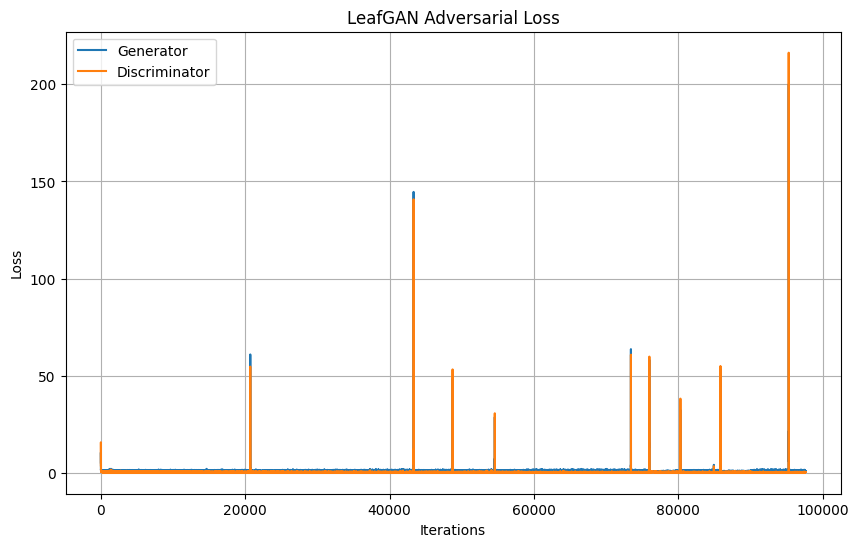

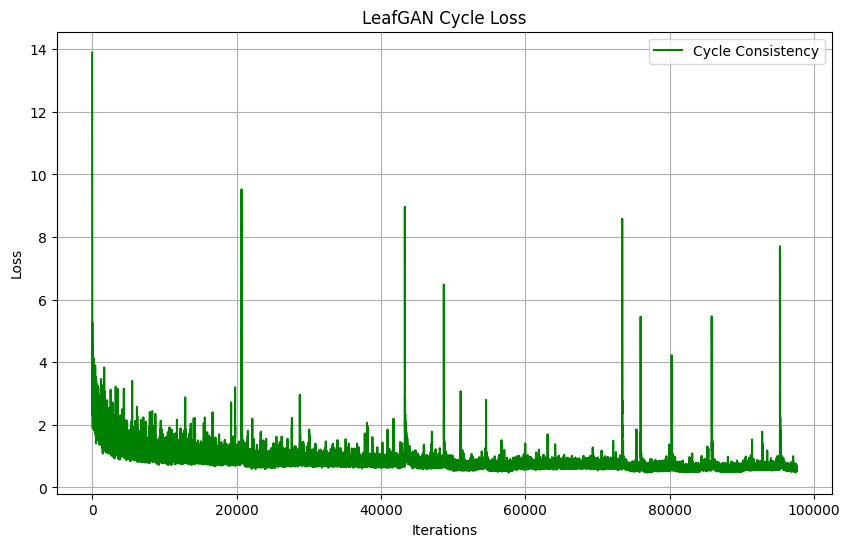

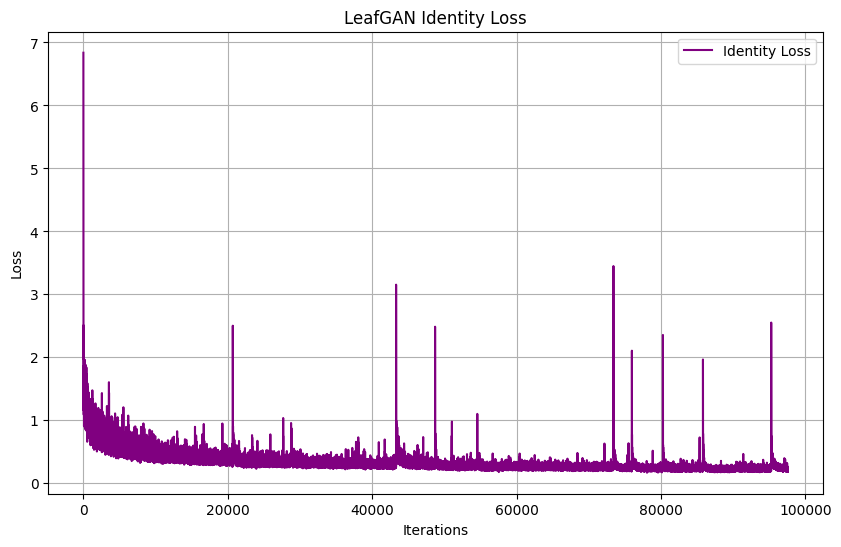

In [ ]:
# ============================================================
# 🌿 LEAFGAN TRAINING — SINGLE CELL (COLAB SAFE & FINAL)
# Mango Leaf Disease Synthesis (Healthy ➜ Anthracnose)
# ============================================================

# ----------------------------
# 🔧 BASIC IMPORTS
# ----------------------------
import os
import sys
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------
# 🔧 PROJECT ROOT (CRITICAL)
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"

assert os.path.exists(LEAFGAN_ROOT), "❌ LeafGAN root path NOT found!"

# Make LeafGAN importable
if LEAFGAN_ROOT not in sys.path:
    sys.path.insert(0, LEAFGAN_ROOT)

# Change working directory (VERY IMPORTANT)
os.chdir(LEAFGAN_ROOT)
print("✅ Working directory:", os.getcwd())

# ----------------------------
# 🔧 LEAFGAN IMPORTS
# ----------------------------
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN modules imported successfully")

# ============================================================
# ⚙️ ARGPARSE FIX FOR COLAB
# ============================================================
sys.argv = [
    "train.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_AnthraDATA",
    "--name", "leafgan_mango_anthracnose",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",

    # ---- Training config (SUPPORTED)
    "--batch_size", "4",
    "--load_size", "256",
    "--crop_size", "256",

    # ---- Optimization (SUPPORTED)
    "--lr", "0.0002",
    "--beta1", "0.5",

    # ---- Network config
    "--netG", "resnet_9blocks",
    "--netD", "basic",
    "--norm", "instance",

    # ---- Runtime safety
    "--no_html"
]


# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TrainOptions().parse()

# Runtime-safe overrides
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []
opt.num_threads = 2
opt.display_id = -1      # disable visdom
opt.serial_batches = False

print("✅ Options parsed successfully")

# --------------------------------------------------
# 🔧 ENSURE CHECKPOINT DIRECTORY EXISTS (CRITICAL)
# --------------------------------------------------
ckpt_dir = os.path.join(opt.checkpoints_dir, opt.name)
os.makedirs(ckpt_dir, exist_ok=True)

print("✅ Checkpoint directory ready:", ckpt_dir)
# ============================================================
# 📦 DATASET & MODEL
# ============================================================
dataset = create_dataset(opt)
print(f"📊 Dataset size: {len(dataset)}")

model = create_model(opt)
model.setup(opt)

print("✅ Model created & setup complete")

# ============================================================
# 📊 LOSS TRACKING
# ============================================================
loss_history = defaultdict(list)

# ============================================================
# 🚀 TRAINING LOOP (LEAFGAN CORRECT)
# ============================================================
print("\n🚀 Starting LeafGAN Training...\n")

total_iters = 0
total_epochs = opt.niter + opt.niter_decay

for epoch in range(opt.epoch_count, total_epochs + 1):
    epoch_iter = 0

    for i, data in enumerate(dataset):
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size

        model.set_input(data)
        model.optimize_parameters()

        losses = model.get_current_losses()

        G_loss = sum(v for k, v in losses.items() if k.startswith("G"))
        D_loss = sum(v for k, v in losses.items() if k.startswith("D"))
        Cycle_loss = sum(v for k, v in losses.items() if "cycle" in k.lower())
        Id_loss = sum(v for k, v in losses.items() if "idt" in k.lower())

        loss_history["G"].append(G_loss)
        loss_history["D"].append(D_loss)
        loss_history["Cycle"].append(Cycle_loss)
        loss_history["Identity"].append(Id_loss)

        if total_iters % opt.print_freq == 0:
            print(
                f"[Epoch {epoch}/{total_epochs}] "
                f"Iter {epoch_iter} | "
                f"G: {G_loss:.4f} | "
                f"D: {D_loss:.4f} | "
                f"Cycle: {Cycle_loss:.4f}"
            )

    # ---- SAVE MODEL (LeafGAN style)
    if epoch % opt.save_epoch_freq == 0:
        model.save_networks(epoch)
        print(f"✅ Epoch {epoch}/{total_epochs} saved\n")

# ============================================================
# 📈 TRAINING PLOTS (SCI-Q1 READY)
# ============================================================
plot_dir = "leafgan_training_plots"
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(loss_history["G"], label="Generator")
plt.plot(loss_history["D"], label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Adversarial Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/adversarial_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Cycle"], label="Cycle Consistency", color="green")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Cycle Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/cycle_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Identity"], label="Identity Loss", color="purple")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Identity Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/identity_loss.png", dpi=300)
plt.show()


In [ ]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_AnthraDATA/trainA"
dst = "/content/drive/MyDrive/LEAFGAN_AnthraDATA/testA"

os.makedirs(dst, exist_ok=True)

for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("✅ testA folder created with healthy images")


✅ testA folder created with healthy images


In [ ]:
import os

os.makedirs("/content/drive/MyDrive/LEAFGAN_AnthraDATA/testB", exist_ok=True)

print("✅ Empty testB folder created")


✅ Empty testB folder created


In [ ]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_AnthraDATA/trainB"
dst = "/content/drive/MyDrive/LEAFGAN_AnthraDATA/testB"

os.makedirs(dst, exist_ok=True)

# copy exactly ONE image
for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))
        break

print("✅ One Anthracnose image copied to testB (LeafGAN-safe)")


✅ One Anthracnose image copied to testB (LeafGAN-safe)


In [ ]:
# ============================================================
# 🌿 LEAFGAN INFERENCE — GENERATE ANTHRACNOSE IMAGES
# ============================================================

import os
import sys
import torch

# ----------------------------
# 🔧 PROJECT ROOT
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
sys.path.insert(0, LEAFGAN_ROOT)
os.chdir(LEAFGAN_ROOT)

from options.test_options import TestOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN inference modules loaded")

# ----------------------------
# ⚙️ FIX ARGPARSE FOR COLAB
# ----------------------------
sys.argv = [
    "test.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_AnthraDATA",
    "--name", "leafgan_mango_anthracnose",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",
    "--num_threads", "2",
    "--batch_size", "1",
    "--load_size", "256",
    "--crop_size", "256",
    "--epoch", "200",          # 👈 USE YOUR CHECKPOINT
    "--phase", "test",
    "--no_dropout",
]

# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TestOptions().parse()
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []

print("✅ Test options parsed")

# ----------------------------
# 📦 LOAD DATA & MODEL
# ----------------------------
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
model.eval()

print("✅ Model loaded from epoch 200")

# ----------------------------
# 📁 OUTPUT DIRECTORY
# ----------------------------
save_dir = os.path.join(
    opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}"
)
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# 🚀 GENERATE IMAGES
# ----------------------------
print("\n🚀 Generating Anthracnose Images...\n")

for i, data in enumerate(dataset):
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()

    fake_B = visuals["fake_B"]   # Anthracnose output
    img_path = model.get_image_paths()[0]

    from util.util import tensor2im
    from PIL import Image

    img = Image.fromarray(tensor2im(fake_B))
    name = os.path.basename(img_path)
    img.save(os.path.join(save_dir, name))

    if i % 50 == 0:
        print(f"Generated {i} images")

print("\n🎉 Anthracnose image generation completed!")
print("📁 Saved at:", save_dir)


✅ LeafGAN inference modules loaded
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_AnthraDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 200                           	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/leafgan_checkpoints/leafgan_mango_anthracnose2/200_net_G_A.pth'

In [ ]:
import os

gen_dir = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/test_200"

files = sorted([f for f in os.listdir(gen_dir) if f.lower().endswith(".jpg")])

for idx, f in enumerate(files, start=1):
    new_name = f"ANT{idx:04d}.jpg"
    os.rename(
        os.path.join(gen_dir, f),
        os.path.join(gen_dir, new_name)
    )

print("✅ Generated images renamed to ANT0001.jpg format")


✅ Generated images renamed to ANT0001.jpg format


In [ ]:
import os
import zipfile

# Path to the folder you want to zip
folder_path = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/test_200"
zip_path = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/result_test_200.zip"

# Create zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, folder_path)
            zipf.write(full_path, arcname)

zip_path


'/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/result_test_200.zip'

In [ ]:
!pip install torch-fidelity

In [ ]:
# ===========================
# LEAFGAN ANTHRACNOSE METRICS
# Real: 512 → 256 | Fake: 256
# ===========================

!pip install -q pytorch-fid lpips scikit-image scikit-learn

import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_fid import fid_score
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.models import inception_v3
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------
# PATHS
# ---------------------------
REAL_DIR = "/content/drive/MyDrive/ANTHRECNOSE/class1"
FAKE_DIR = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/test_200"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256

# ---------------------------
# TRANSFORMS
# ---------------------------
resize_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

lpips_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ---------------------------
# LOAD IMAGES
# ---------------------------
def load_imgs(path, tf):
    imgs = []
    for f in sorted(os.listdir(path)):
        img = Image.open(os.path.join(path, f)).convert("RGB")
        imgs.append(tf(img))
    return torch.stack(imgs)

real_imgs = load_imgs(REAL_DIR, resize_tf)
fake_imgs = load_imgs(FAKE_DIR, resize_tf)

N = min(len(real_imgs), len(fake_imgs))
real_imgs = real_imgs[:N]
fake_imgs = fake_imgs[:N]

print(f"✅ Using {N} aligned real & fake Anthracnose images")

# =====================
# 1️⃣ FID (pytorch-fid)
# =====================
fid_value = fid_score.calculate_fid_given_paths(
    [REAL_DIR, FAKE_DIR],
    batch_size=32,
    device=DEVICE,
    dims=2048
)

# =====================
# 2️⃣ SSIM & PSNR
# =====================
ssim_scores, psnr_scores = [], []

for r, f in zip(real_imgs, fake_imgs):
    r_np = r.permute(1,2,0).numpy()
    f_np = f.permute(1,2,0).numpy()
    ssim_scores.append(ssim(r_np, f_np, channel_axis=2, data_range=1.0))
    psnr_scores.append(psnr(r_np, f_np, data_range=1.0))

mean_ssim = np.mean(ssim_scores)
mean_psnr = np.mean(psnr_scores)

# =====================
# 3️⃣ LPIPS
# =====================
lpips_model = lpips.LPIPS(net="alex").to(DEVICE)

real_lp = load_imgs(REAL_DIR, lpips_tf).to(DEVICE)[:N]
fake_lp = load_imgs(FAKE_DIR, lpips_tf).to(DEVICE)[:N]

lpips_scores = []
for r, f in zip(real_lp, fake_lp):
    lpips_scores.append(lpips_model(r.unsqueeze(0), f.unsqueeze(0)).item())

mean_lpips = np.mean(lpips_scores)

# =====================
# 4️⃣ Precision / Recall / F1
# =====================
from torchvision.models import inception_v3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

inception = inception_v3(pretrained=True).to(DEVICE)
inception.aux_logits = False
inception.eval()

def extract_feats(imgs):
    feats = []
    with torch.no_grad():
        for img in imgs.to(DEVICE):
            feat = inception(img.unsqueeze(0))
            feats.append(feat.cpu().numpy().flatten())
    return np.array(feats)

real_feats = extract_feats(real_imgs)
fake_feats = extract_feats(fake_imgs)

sim = cosine_similarity(fake_feats, real_feats)
threshold = 0.7

y_pred = (sim.max(axis=1) > threshold).astype(int)
y_true = np.ones(len(y_pred))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


# =====================
# 📊 RESULTS
# =====================
print("\n📊 LEAFGAN – ANTHRACNOSE EVALUATION")
print("====================================")
print(f"FID Score     : {fid_value:.3f}   ↓")
print(f"SSIM          : {mean_ssim:.4f}   ↑")
print(f"LPIPS         : {mean_lpips:.4f}  ↓")
print(f"PSNR (dB)     : {mean_psnr:.2f}   ↑")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1-score      : {f1:.4f}")
print("====================================")


✅ Using 886 aligned real & fake Anthracnose images


100%|██████████| 61/61 [00:06<00:00,  8.78it/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 121MB/s] 



📊 LEAFGAN – ANTHRACNOSE EVALUATION
FID Score     : 102.434   ↓
SSIM          : 0.4772   ↑
LPIPS         : 0.5710  ↓
PSNR (dB)     : 12.18   ↑
Precision     : 1.0000
Recall        : 0.6580
F1-score      : 0.7937


In [ ]:
# ============================================================
# 🌿 LEAFGAN INFERENCE — GENERATE ANTHRACNOSE IMAGES
# ============================================================

import os
import sys
import torch

# ----------------------------
# 🔧 PROJECT ROOT
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
sys.path.insert(0, LEAFGAN_ROOT)
os.chdir(LEAFGAN_ROOT)

from options.test_options import TestOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN inference modules loaded")

# ----------------------------
# ⚙️ FIX ARGPARSE FOR COLAB
# ----------------------------
sys.argv = [
    "test.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_AnthraDATA",
    "--name", "leafgan_mango_anthracnose",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",
    "--num_threads", "2",
    "--batch_size", "1",
    "--load_size", "256",
    "--crop_size", "256",
    "--epoch", "200",          # 👈 USE YOUR CHECKPOINT
    "--phase", "test",
    "--no_dropout",
]

# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TestOptions().parse()
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []

print("✅ Test options parsed")

# ----------------------------
# 📦 LOAD DATA & MODEL
# ----------------------------
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
model.eval()

print("✅ Model loaded from epoch 200")

# ----------------------------
# 📁 OUTPUT DIRECTORY
# ----------------------------
save_dir = os.path.join(
    opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}"
)
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# 🚀 GENERATE IMAGES
# ----------------------------
print("\n🚀 Generating Anthracnose Images...\n")

for i, data in enumerate(dataset):
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()

    fake_B = visuals["fake_B"]   # Anthracnose output
    img_path = model.get_image_paths()[0]

    from util.util import tensor2im
    from PIL import Image

    img = Image.fromarray(tensor2im(fake_B))
    name = os.path.basename(img_path)
    img.save(os.path.join(save_dir, name))

    if i % 50 == 0:
        print(f"Generated {i} images")

print("\n🎉 Anthracnose image generation completed!")
print("📁 Saved at:", save_dir)


In [1]:
# ============================================================
# 🌿 LEAFGAN INFERENCE — GENERATE HEALTHY LEAF IMAGES
# (Anthracnose ➜ Healthy | Epoch-200)
# ============================================================

import os
import sys
import torch
from PIL import Image

# ----------------------------
# 🔧 PROJECT ROOT
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
sys.path.insert(0, LEAFGAN_ROOT)
os.chdir(LEAFGAN_ROOT)

from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.util import tensor2im

print("✅ LeafGAN inference modules loaded")

# ----------------------------
# ⚙️ FIX ARGPARSE FOR COLAB
# ----------------------------
sys.argv = [
    "test.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_AnthraDATA",
    "--name", "leafgan_mango_anthracnose",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "BtoA",        # 👈 Anthracnose → Healthy
    "--num_threads", "2",
    "--batch_size", "1",
    "--load_size", "256",
    "--crop_size", "256",
    "--epoch", "200",             # 👈 Use epoch-200 checkpoint
    "--phase", "test",
    "--no_dropout",
]

# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TestOptions().parse()
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []

print("✅ Test options parsed")

# ----------------------------
# 📦 LOAD DATA & MODEL
# ----------------------------
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
model.eval()

print("✅ Model loaded from epoch 200")

# ----------------------------
# 📁 OUTPUT DIRECTORY
# ----------------------------
save_dir = os.path.join(
    opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}_HEALTHY"
)
os.makedirs(save_dir, exist_ok=True)

print("📁 Output directory:", save_dir)

# ----------------------------
# 🚀 GENERATE HEALTHY IMAGES
# ----------------------------
print("\n🚀 Generating Healthy Leaf Images...\n")

counter = 1

for data in dataset:
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()

    fake_A = visuals["fake_A"]  # 👈 Healthy output
    img = Image.fromarray(tensor2im(fake_A))

    filename = f"HEA{counter:04d}.jpg"
    img.save(os.path.join(save_dir, filename))

    if counter % 50 == 0:
        print(f"Generated {counter} healthy images")

    counter += 1

print("\n🎉 Healthy leaf image generation completed!")
print(f"✅ Total images generated: {counter-1}")
print("📁 Saved at:", save_dir)


✅ LeafGAN inference modules loaded
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_AnthraDATA	[default: None]
             dataset_mode: unaligned                     
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: 200                           	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                  

In [2]:
import os
import zipfile

# Path to generated healthy images
RESULT_DIR = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/test_200_HEALTHY"
ZIP_PATH = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/leafgan_healthy_test_200.zip"

# Create zip
with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(RESULT_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, RESULT_DIR)
            zipf.write(full_path, arcname)

ZIP_PATH


'/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_anthracnose/leafgan_healthy_test_200.zip'

In [1]:

#SET ROOT PATH OF HEALTHY AND DISEASED LEAF
import os, shutil

healthy_src = "/content/drive/MyDrive/HEALTHY"
anthracnose_src = "/content/drive/MyDrive/LEAFBLIGHT"

leafgan_root = "/content/drive/MyDrive/LEAFGAN_LBDATA"
trainA = os.path.join(leafgan_root, "trainA")  # Healthy
trainB = os.path.join(leafgan_root, "trainB")  # Anthracnose

os.makedirs(trainA, exist_ok=True)
os.makedirs(trainB, exist_ok=True)

# Copy Healthy images → trainA
for f in os.listdir(healthy_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(healthy_src, f), trainA)

# Copy Anthracnose images → trainB
for f in os.listdir(anthracnose_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(anthracnose_src, f), trainB)

print("✅ LeafGAN dataset created successfully")
print("Healthy → trainA | LEAFBLIGHT → trainB")


✅ LeafGAN dataset created successfully
Healthy → trainA | LEAFBLIGHT → trainB


✅ Working directory: /content/drive/MyDrive/LeafGAN-master
✅ LeafGAN modules imported successfully
----------------- Options ---------------
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_LBDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          d

/content/drive/MyDrive/LeafGAN-master/models/base_model.py:140: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number


[Epoch 1/200] Iter 100 | G: 1.2733 | D: 1.0173 | Cycle: 5.4565
[Epoch 1/200] Iter 200 | G: 0.6401 | D: 0.6358 | Cycle: 2.6812
[Epoch 1/200] Iter 300 | G: 0.7178 | D: 0.6958 | Cycle: 2.5007
[Epoch 1/200] Iter 400 | G: 0.5613 | D: 0.5596 | Cycle: 3.3043
[Epoch 1/200] Iter 500 | G: 0.5843 | D: 0.5951 | Cycle: 2.8024
[Epoch 1/200] Iter 600 | G: 0.5808 | D: 0.6101 | Cycle: 2.3107
[Epoch 1/200] Iter 700 | G: 0.6581 | D: 0.5803 | Cycle: 2.8113
[Epoch 1/200] Iter 800 | G: 0.8799 | D: 0.8051 | Cycle: 2.6171
[Epoch 1/200] Iter 900 | G: 0.6601 | D: 0.5534 | Cycle: 2.4853
[Epoch 1/200] Iter 1000 | G: 0.6063 | D: 0.5524 | Cycle: 2.0767
[Epoch 1/200] Iter 1100 | G: 0.5660 | D: 0.5400 | Cycle: 1.9723
[Epoch 1/200] Iter 1200 | G: 0.5863 | D: 0.5255 | Cycle: 1.9134
[Epoch 1/200] Iter 1300 | G: 0.5564 | D: 0.5900 | Cycle: 3.4461
[Epoch 1/200] Iter 1400 | G: 0.5923 | D: 0.4694 | Cycle: 2.2748
[Epoch 1/200] Iter 1500 | G: 0.5349 | D: 0.6395 | Cycle: 2.4098
[Epoch 1/200] Iter 1600 | G: 0.5485 | D: 0.5509 |

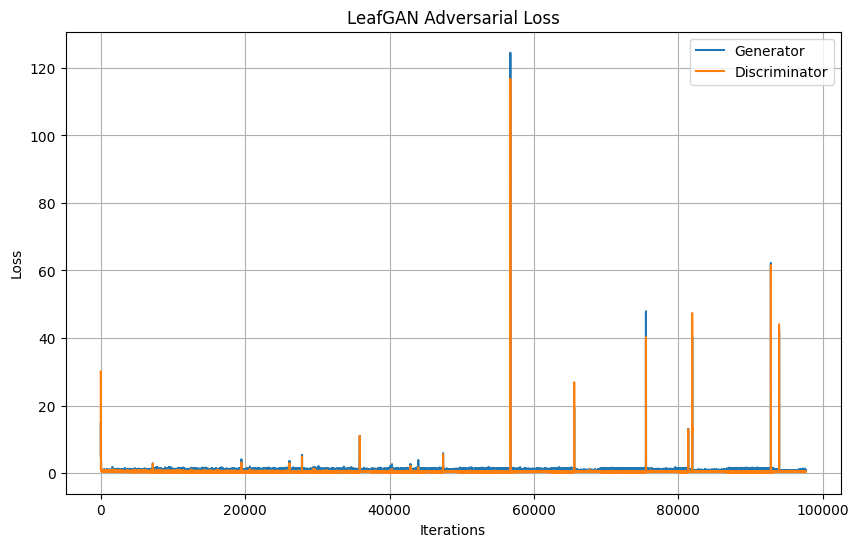

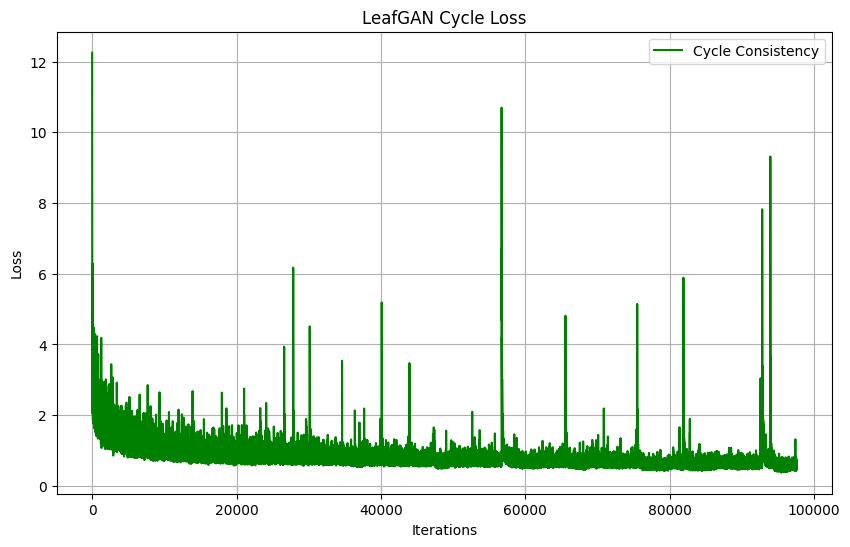

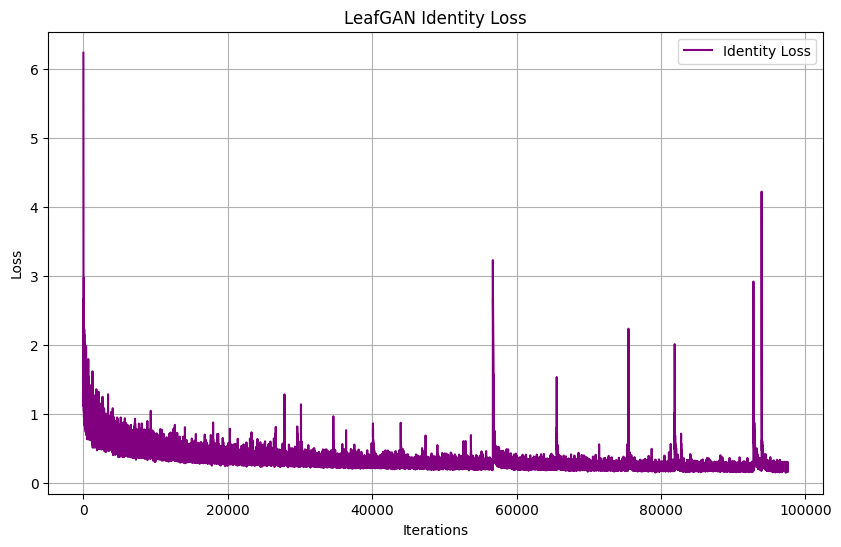

In [2]:
# ============================================================
# 🌿 LEAFGAN TRAINING — SINGLE CELL (COLAB SAFE & FINAL)
# Mango Leaf Disease Synthesis (Healthy ➜ LEAFBLIGHT)
# ============================================================

# ----------------------------
# 🔧 BASIC IMPORTS
# ----------------------------
import os
import sys
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------
# 🔧 PROJECT ROOT (CRITICAL)
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"

assert os.path.exists(LEAFGAN_ROOT), "❌ LeafGAN root path NOT found!"

# Make LeafGAN importable
if LEAFGAN_ROOT not in sys.path:
    sys.path.insert(0, LEAFGAN_ROOT)

# Change working directory (VERY IMPORTANT)
os.chdir(LEAFGAN_ROOT)
print("✅ Working directory:", os.getcwd())

# ----------------------------
# 🔧 LEAFGAN IMPORTS
# ----------------------------
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN modules imported successfully")

# ============================================================
# ⚙️ ARGPARSE FIX FOR COLAB
# ============================================================
sys.argv = [
    "train.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_LBDATA",
    "--name", "leafgan_mango_LEAFBLIGHT",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",

    # ---- Training config (SUPPORTED)
    "--batch_size", "4",
    "--load_size", "256",
    "--crop_size", "256",

    # ---- Optimization (SUPPORTED)
    "--lr", "0.0002",
    "--beta1", "0.5",

    # ---- Network config
    "--netG", "resnet_9blocks",
    "--netD", "basic",
    "--norm", "instance",

    # ---- Runtime safety
    "--no_html"
]


# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TrainOptions().parse()

# Runtime-safe overrides
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []
opt.num_threads = 2
opt.display_id = -1      # disable visdom
opt.serial_batches = False

print("✅ Options parsed successfully")

# --------------------------------------------------
# 🔧 ENSURE CHECKPOINT DIRECTORY EXISTS (CRITICAL)
# --------------------------------------------------
ckpt_dir = os.path.join(opt.checkpoints_dir, opt.name)
os.makedirs(ckpt_dir, exist_ok=True)

print("✅ Checkpoint directory ready:", ckpt_dir)
# ============================================================
# 📦 DATASET & MODEL
# ============================================================
dataset = create_dataset(opt)
print(f"📊 Dataset size: {len(dataset)}")

model = create_model(opt)
model.setup(opt)

print("✅ Model created & setup complete")

# ============================================================
# 📊 LOSS TRACKING
# ============================================================
loss_history = defaultdict(list)

# ============================================================
# 🚀 TRAINING LOOP (LEAFGAN CORRECT)
# ============================================================
print("\n🚀 Starting LeafGAN Training...\n")

total_iters = 0
total_epochs = opt.niter + opt.niter_decay

for epoch in range(opt.epoch_count, total_epochs + 1):
    epoch_iter = 0

    for i, data in enumerate(dataset):
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size

        model.set_input(data)
        model.optimize_parameters()

        losses = model.get_current_losses()

        G_loss = sum(v for k, v in losses.items() if k.startswith("G"))
        D_loss = sum(v for k, v in losses.items() if k.startswith("D"))
        Cycle_loss = sum(v for k, v in losses.items() if "cycle" in k.lower())
        Id_loss = sum(v for k, v in losses.items() if "idt" in k.lower())

        loss_history["G"].append(G_loss)
        loss_history["D"].append(D_loss)
        loss_history["Cycle"].append(Cycle_loss)
        loss_history["Identity"].append(Id_loss)

        if total_iters % opt.print_freq == 0:
            print(
                f"[Epoch {epoch}/{total_epochs}] "
                f"Iter {epoch_iter} | "
                f"G: {G_loss:.4f} | "
                f"D: {D_loss:.4f} | "
                f"Cycle: {Cycle_loss:.4f}"
            )

    # ---- SAVE MODEL (LeafGAN style)
    if epoch % opt.save_epoch_freq == 0:
        model.save_networks(epoch)
        print(f"✅ Epoch {epoch}/{total_epochs} saved\n")

# ============================================================
# 📈 TRAINING PLOTS (SCI-Q1 READY)
# ============================================================
plot_dir = "leafgan_training_plots"
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(loss_history["G"], label="Generator")
plt.plot(loss_history["D"], label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Adversarial Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/adversarial_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Cycle"], label="Cycle Consistency", color="green")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Cycle Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/cycle_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Identity"], label="Identity Loss", color="purple")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Identity Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/identity_loss.png", dpi=300)
plt.show()


In [4]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_LBDATA/trainA"
dst = "/content/drive/MyDrive/LEAFGAN_LBDATA/testA"

os.makedirs(dst, exist_ok=True)

for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("✅ testA folder created with healthy images")


✅ testA folder created with healthy images


In [5]:
import os

os.makedirs("/content/drive/MyDrive/LEAFGAN_LBDATA/testB", exist_ok=True)

print("✅ Empty testB folder created")


✅ Empty testB folder created


In [6]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_LBDATA/trainB"
dst = "/content/drive/MyDrive/LEAFGAN_LBDATA/testB"

os.makedirs(dst, exist_ok=True)

# copy exactly ONE image
for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))
        break

print("✅ One LEAFBLIGHT image copied to testB (LeafGAN-safe)")


✅ One LEAFBLIGHT image copied to testB (LeafGAN-safe)


In [7]:
# ============================================================
# 🌿 LEAFGAN INFERENCE — GENERATE LEAFBLIGHT IMAGES
# ============================================================

import os
import sys
import torch

# ----------------------------
# 🔧 PROJECT ROOT
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
sys.path.insert(0, LEAFGAN_ROOT)
os.chdir(LEAFGAN_ROOT)

from options.test_options import TestOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN inference modules loaded")

# ----------------------------
# ⚙️ FIX ARGPARSE FOR COLAB
# ----------------------------
sys.argv = [
    "test.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_LBDATA",
    "--name", "leafgan_mango_LEAFBLIGHT",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",
    "--num_threads", "2",
    "--batch_size", "1",
    "--load_size", "256",
    "--crop_size", "256",
    "--epoch", "200",          # 👈 USE YOUR CHECKPOINT
    "--phase", "test",
    "--no_dropout",
]

# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TestOptions().parse()
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []

print("✅ Test options parsed")

# ----------------------------
# 📦 LOAD DATA & MODEL
# ----------------------------
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
model.eval()

print("✅ Model loaded from epoch 200")

# ----------------------------
# 📁 OUTPUT DIRECTORY
# ----------------------------
save_dir = os.path.join(
    opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}"
)
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# 🚀 GENERATE IMAGES
# ----------------------------
print("\n🚀 Generating LEAFBLIGHT Images...\n")

for i, data in enumerate(dataset):
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()

    fake_B = visuals["fake_B"]   # Anthracnose output
    img_path = model.get_image_paths()[0]

    from util.util import tensor2im
    from PIL import Image

    img = Image.fromarray(tensor2im(fake_B))
    name = os.path.basename(img_path)
    img.save(os.path.join(save_dir, name))

    if i % 50 == 0:
        print(f"Generated {i} images")

print("\n🎉 LEAFBLIGHT image generation completed!")
print("📁 Saved at:", save_dir)


✅ LeafGAN inference modules loaded
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_LBDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 200                           	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: No

In [8]:
import os
import zipfile

# Path to generated healthy LB images
RESULT_DIR = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_LEAFBLIGHT/test_200"
ZIP_PATH = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_LEAFBLIGHT/test_200.zip"

# Create zip
with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(RESULT_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, RESULT_DIR)
            zipf.write(full_path, arcname)

ZIP_PATH


'/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_LEAFBLIGHT/test_200.zip'

In [9]:

#SET ROOT PATH OF HEALTHY AND DISEASED LEAF
import os, shutil

healthy_src = "/content/drive/MyDrive/HEALTHY"
anthracnose_src = "/content/drive/MyDrive/GALLMILDGEDAMAGE"

leafgan_root = "/content/drive/MyDrive/LEAFGAN_GMDATA"
trainA = os.path.join(leafgan_root, "trainA")  # Healthy
trainB = os.path.join(leafgan_root, "trainB")  # Anthracnose

os.makedirs(trainA, exist_ok=True)
os.makedirs(trainB, exist_ok=True)

# Copy Healthy images → trainA
for f in os.listdir(healthy_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(healthy_src, f), trainA)

# Copy Anthracnose images → trainB
for f in os.listdir(anthracnose_src):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(anthracnose_src, f), trainB)

print("✅ LeafGAN dataset created successfully")
print("Healthy → trainA | GALLMIDGE → trainB")


✅ LeafGAN dataset created successfully
Healthy → trainA | GALLMIDGE → trainB


✅ Working directory: /content/drive/MyDrive/LeafGAN-master
✅ LeafGAN modules imported successfully
----------------- Options ---------------
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_GMDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          d

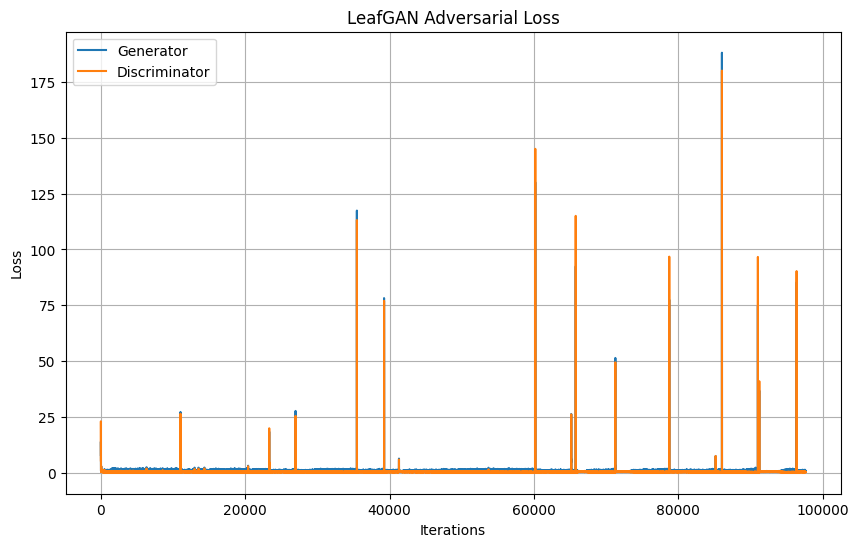

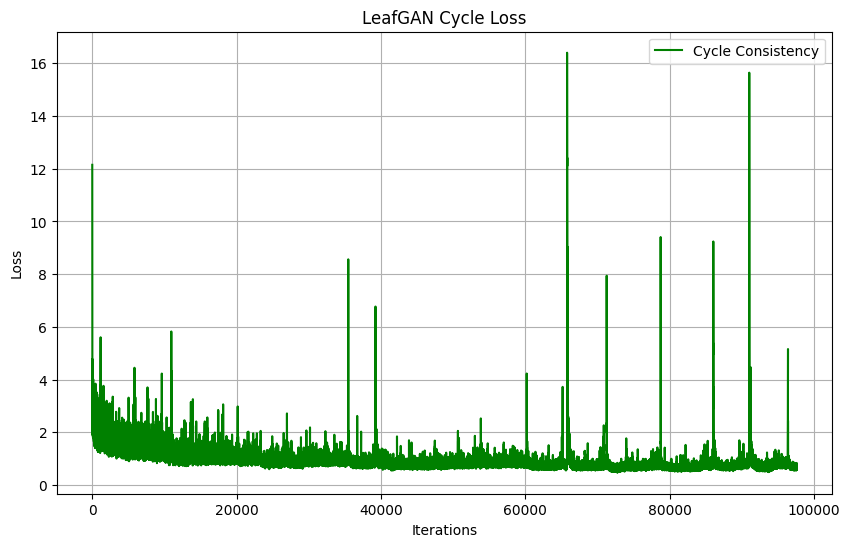

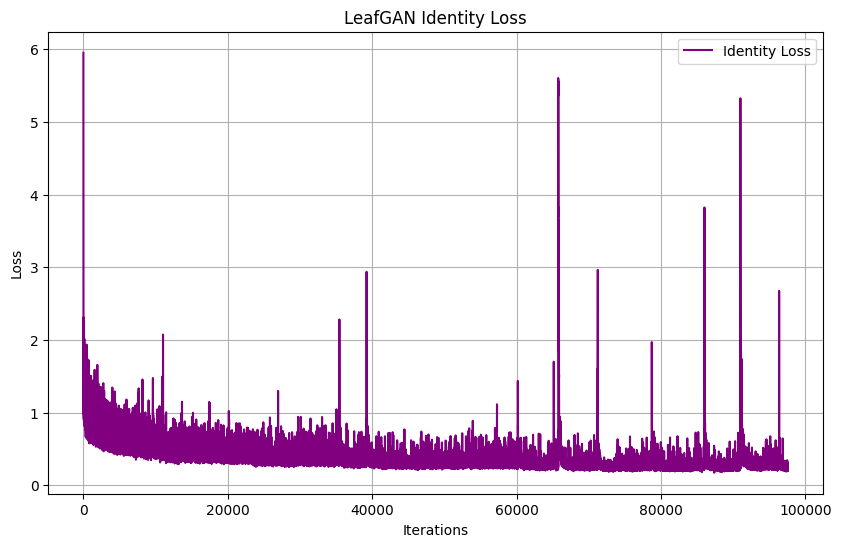

In [11]:
# ============================================================
# 🌿 LEAFGAN TRAINING — SINGLE CELL (COLAB SAFE & FINAL)
# Mango Leaf Disease Synthesis (Healthy ➜ GALLMIDGEDAMAGE)
# ============================================================

# ----------------------------
# 🔧 BASIC IMPORTS
# ----------------------------
import os
import sys
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------
# 🔧 PROJECT ROOT (CRITICAL)
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"

assert os.path.exists(LEAFGAN_ROOT), "❌ LeafGAN root path NOT found!"

# Make LeafGAN importable
if LEAFGAN_ROOT not in sys.path:
    sys.path.insert(0, LEAFGAN_ROOT)

# Change working directory (VERY IMPORTANT)
os.chdir(LEAFGAN_ROOT)
print("✅ Working directory:", os.getcwd())

# ----------------------------
# 🔧 LEAFGAN IMPORTS
# ----------------------------
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN modules imported successfully")

# ============================================================
# ⚙️ ARGPARSE FIX FOR COLAB
# ============================================================
sys.argv = [
    "train.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_GMDATA",
    "--name", "leafgan_mango_GALLMIDGEDAMAGE",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",

    # ---- Training config (SUPPORTED)
    "--batch_size", "4",
    "--load_size", "256",
    "--crop_size", "256",

    # ---- Optimization (SUPPORTED)
    "--lr", "0.0002",
    "--beta1", "0.5",

    # ---- Network config
    "--netG", "resnet_9blocks",
    "--netD", "basic",
    "--norm", "instance",

    # ---- Runtime safety
    "--no_html"
]


# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TrainOptions().parse()

# Runtime-safe overrides
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []
opt.num_threads = 2
opt.display_id = -1      # disable visdom
opt.serial_batches = False

print("✅ Options parsed successfully")

# --------------------------------------------------
# 🔧 ENSURE CHECKPOINT DIRECTORY EXISTS (CRITICAL)
# --------------------------------------------------
ckpt_dir = os.path.join(opt.checkpoints_dir, opt.name)
os.makedirs(ckpt_dir, exist_ok=True)

print("✅ Checkpoint directory ready:", ckpt_dir)
# ============================================================
# 📦 DATASET & MODEL
# ============================================================
dataset = create_dataset(opt)
print(f"📊 Dataset size: {len(dataset)}")

model = create_model(opt)
model.setup(opt)

print("✅ Model created & setup complete")

# ============================================================
# 📊 LOSS TRACKING
# ============================================================
loss_history = defaultdict(list)

# ============================================================
# 🚀 TRAINING LOOP (LEAFGAN CORRECT)
# ============================================================
print("\n🚀 Starting LeafGAN Training...\n")

total_iters = 0
total_epochs = opt.niter + opt.niter_decay

for epoch in range(opt.epoch_count, total_epochs + 1):
    epoch_iter = 0

    for i, data in enumerate(dataset):
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size

        model.set_input(data)
        model.optimize_parameters()

        losses = model.get_current_losses()

        G_loss = sum(v for k, v in losses.items() if k.startswith("G"))
        D_loss = sum(v for k, v in losses.items() if k.startswith("D"))
        Cycle_loss = sum(v for k, v in losses.items() if "cycle" in k.lower())
        Id_loss = sum(v for k, v in losses.items() if "idt" in k.lower())

        loss_history["G"].append(G_loss)
        loss_history["D"].append(D_loss)
        loss_history["Cycle"].append(Cycle_loss)
        loss_history["Identity"].append(Id_loss)

        if total_iters % opt.print_freq == 0:
            print(
                f"[Epoch {epoch}/{total_epochs}] "
                f"Iter {epoch_iter} | "
                f"G: {G_loss:.4f} | "
                f"D: {D_loss:.4f} | "
                f"Cycle: {Cycle_loss:.4f}"
            )

    # ---- SAVE MODEL (LeafGAN style)
    if epoch % opt.save_epoch_freq == 0:
        model.save_networks(epoch)
        print(f"✅ Epoch {epoch}/{total_epochs} saved\n")

# ============================================================
# 📈 TRAINING PLOTS (SCI-Q1 READY)
# ============================================================
plot_dir = "leafgan_training_plots"
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(loss_history["G"], label="Generator")
plt.plot(loss_history["D"], label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Adversarial Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/adversarial_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Cycle"], label="Cycle Consistency", color="green")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Cycle Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/cycle_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_history["Identity"], label="Identity Loss", color="purple")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("LeafGAN Identity Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{plot_dir}/identity_loss.png", dpi=300)
plt.show()


In [12]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_GMDATA/trainA"
dst = "/content/drive/MyDrive/LEAFGAN_GMDATA/testA"

os.makedirs(dst, exist_ok=True)

for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("✅ testA folder created with healthy images")


✅ testA folder created with healthy images


In [13]:
import os

os.makedirs("/content/drive/MyDrive/LEAFGAN_GMDATA/testB", exist_ok=True)

print("✅ Empty testB folder created")


✅ Empty testB folder created


In [14]:
import os
import shutil

src = "/content/drive/MyDrive/LEAFGAN_GMDATA/trainB"
dst = "/content/drive/MyDrive/LEAFGAN_GMDATA/testB"

os.makedirs(dst, exist_ok=True)

# copy exactly ONE image
for f in os.listdir(src):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))
        break

print("✅ One LEAFBLIGHT image copied to testB (LeafGAN-safe)")


✅ One LEAFBLIGHT image copied to testB (LeafGAN-safe)


In [15]:
# ============================================================
# 🌿 LEAFGAN INFERENCE — GENERATE GALLMIDGE IMAGES
# ============================================================

import os
import sys
import torch

# ----------------------------
# 🔧 PROJECT ROOT
# ----------------------------
LEAFGAN_ROOT = "/content/drive/MyDrive/LeafGAN-master"
sys.path.insert(0, LEAFGAN_ROOT)
os.chdir(LEAFGAN_ROOT)

from options.test_options import TestOptions
from data import create_dataset
from models import create_model

print("✅ LeafGAN inference modules loaded")

# ----------------------------
# ⚙️ FIX ARGPARSE FOR COLAB
# ----------------------------
sys.argv = [
    "test.py",
    "--dataroot", "/content/drive/MyDrive/LEAFGAN_GMDATA",
    "--name", "leafgan_mango_GALLMIDGEDAMAGE",
    "--model", "leaf_gan",
    "--dataset_mode", "unaligned",
    "--direction", "AtoB",
    "--num_threads", "2",
    "--batch_size", "1",
    "--load_size", "256",
    "--crop_size", "256",
    "--epoch", "200",          # 👈 USE YOUR CHECKPOINT
    "--phase", "test",
    "--no_dropout",
]

# ----------------------------
# 📌 PARSE OPTIONS
# ----------------------------
opt = TestOptions().parse()
opt.checkpoints_dir = "/content/drive/MyDrive/leafgan_checkpoints"
opt.gpu_ids = [0] if torch.cuda.is_available() else []

print("✅ Test options parsed")

# ----------------------------
# 📦 LOAD DATA & MODEL
# ----------------------------
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
model.eval()

print("✅ Model loaded from epoch 200")

# ----------------------------
# 📁 OUTPUT DIRECTORY
# ----------------------------
save_dir = os.path.join(
    opt.results_dir, opt.name, f"{opt.phase}_{opt.epoch}"
)
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# 🚀 GENERATE IMAGES
# ----------------------------
print("\n🚀 Generating GALLMIDGE Images...\n")

for i, data in enumerate(dataset):
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()

    fake_B = visuals["fake_B"]   # Anthracnose output
    img_path = model.get_image_paths()[0]

    from util.util import tensor2im
    from PIL import Image

    img = Image.fromarray(tensor2im(fake_B))
    name = os.path.basename(img_path)
    img.save(os.path.join(save_dir, name))

    if i % 50 == 0:
        print(f"Generated {i} images")

print("\n🎉 GALLMIDGE image generation completed!")
print("📁 Saved at:", save_dir)


✅ LeafGAN inference modules loaded
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/LEAFGAN_GMDATA	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 200                           	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: No

In [16]:
import os
import zipfile

# Path to generated healthy LB images
RESULT_DIR = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_GALLMIDGEDAMAGE/test_200"
ZIP_PATH = "/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_GALLMIDGEDAMAGE/test_200.zip"

# Create zip
with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(RESULT_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, RESULT_DIR)
            zipf.write(full_path, arcname)

ZIP_PATH


'/content/drive/MyDrive/LeafGAN-master/results/leafgan_mango_GALLMIDGEDAMAGE/test_200.zip'